In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
data = pd.read_csv("/Users/jacopobinati/Desktop/Prediction ML/assignment1/DA3-phdma/HM1/morg-2014-emp.csv")
data
print(data.describe())

#Data imported correctly since we have 149316 observations

/var/folders/6t/d3d0rh5d1rd426bk9g_mnhd00000gn/T/ipykernel_62926/3963781743.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/Users/jacopobinati/Desktop/Prediction ML/assignment1/DA3-phdma/HM1/morg-2014-emp.csv")


          Unnamed: 0          hhid         weight        earnwke  \
count  149316.000000  1.493160e+05  149316.000000  149316.000000   
mean   158796.895095  4.510656e+14    2375.618819     888.834343   
std     91294.406095  3.227225e+14    1295.345801     643.737322   
min         3.000000  5.893210e+09      53.232500       0.010000   
25%     79751.500000  1.368508e+14    1271.730300     430.000000   
50%    158971.500000  4.114799e+14    2662.681950     719.600000   
75%    237719.250000  7.340299e+14    3319.093575    1153.840000   
max    317056.000000  9.999907e+14   24595.832400    2884.610000   

              uhours        grade92           race        ethnic  \
count  149316.000000  149316.000000  149316.000000  20071.000000   
mean       38.939819      40.807958       1.424456      2.549250   
std        10.259280       2.502888       1.333825      2.382705   
min         1.000000      31.000000       1.000000      1.000000   
25%        40.000000      39.000000       1.000

We will keep only workers in the cathegory: Medial and health services manager. 
The Census Code is: 0350
The SOC CODE is 11-9111

In [4]:
data = data[(data['occ2012'] >= 3000) & (data['occ2012'] <= 3540)]
summary = data.describe()
summary_code = data['occ2012'].describe()

# create the variable wage per hour: w
data['w'] = data['earnwke'] / data['uhours']
data['lnw'] = np.log(data['w'])
data['agesqr'] = data['age']**2

#rewrite the variable sex as follows: 1 for Male and 0 for Female
data['sex'] = data['sex'].replace({1: 1, 2: 0})

# create a new var which create a list of values for each state
states = sorted(data['stfips'].unique())
state_code = {state: code for code, state in enumerate(states, start=1)}
data['state_code'] = data['stfips'].map(state_code)

print(state_code)
print(data.describe())
data["sex"].value_counts()

{'AK': 1, 'AL': 2, 'AR': 3, 'AZ': 4, 'CA': 5, 'CO': 6, 'CT': 7, 'DC': 8, 'DE': 9, 'FL': 10, 'GA': 11, 'HI': 12, 'IA': 13, 'ID': 14, 'IL': 15, 'IN': 16, 'KS': 17, 'KY': 18, 'LA': 19, 'MA': 20, 'MD': 21, 'ME': 22, 'MI': 23, 'MN': 24, 'MO': 25, 'MS': 26, 'MT': 27, 'NC': 28, 'ND': 29, 'NE': 30, 'NH': 31, 'NJ': 32, 'NM': 33, 'NV': 34, 'NY': 35, 'OH': 36, 'OK': 37, 'OR': 38, 'PA': 39, 'RI': 40, 'SC': 41, 'SD': 42, 'TN': 43, 'TX': 44, 'UT': 45, 'VA': 46, 'VT': 47, 'WA': 48, 'WI': 49, 'WV': 50, 'WY': 51}
          Unnamed: 0          hhid        weight      earnwke       uhours  \
count    9208.000000  9.208000e+03   9208.000000  9208.000000  9208.000000   
mean   158974.524001  4.419978e+14   2345.592281  1124.188752    38.541486   
std     91551.693501  3.234487e+14   1245.960075   658.624137     9.863961   
min        25.000000  1.840306e+10     65.994300     0.010000     1.000000   
25%     79971.250000  1.298540e+14   1274.854450   660.000000    36.000000   
50%    158963.500000  4.046046

sex
0    7220
1    1988
Name: count, dtype: int64

In [5]:
unique_states = data['stfips'].unique()
state_code_map = {state: code for code, state in enumerate(unique_states, start=1)}
data['state_code'] = data['stfips'].map(state_code_map)
print(state_code_map)

{'AL': 1, 'AK': 2, 'AZ': 3, 'AR': 4, 'CA': 5, 'CO': 6, 'CT': 7, 'DE': 8, 'DC': 9, 'FL': 10, 'GA': 11, 'HI': 12, 'ID': 13, 'IL': 14, 'IN': 15, 'IA': 16, 'KS': 17, 'KY': 18, 'LA': 19, 'ME': 20, 'MD': 21, 'MA': 22, 'MI': 23, 'MN': 24, 'MS': 25, 'MO': 26, 'MT': 27, 'NE': 28, 'NV': 29, 'NH': 30, 'NJ': 31, 'NY': 32, 'NC': 33, 'ND': 34, 'OH': 35, 'OK': 36, 'OR': 37, 'PA': 38, 'RI': 39, 'SC': 40, 'SD': 41, 'TN': 42, 'TX': 43, 'UT': 44, 'VT': 45, 'VA': 46, 'WA': 47, 'WV': 48, 'WI': 49, 'WY': 50, 'NM': 51}


In [7]:
# Getting some insights regarding the dataset
columns_of_interest = ['earnwke', 'uhours', 'w', 'agesqr'] 
specific_columns_stats = data[columns_of_interest].describe()
print(specific_columns_stats)

           earnwke       uhours            w       agesqr
count  9208.000000  9208.000000  9208.000000  9208.000000
mean   1124.188752    38.541486    29.366761  1903.663445
std     658.624137     9.863961    16.773557  1005.349490
min       0.010000     1.000000     0.000200   289.000000
25%     660.000000    36.000000    17.667500  1024.000000
50%     980.000000    40.000000    26.000000  1764.000000
75%    1420.200000    40.000000    37.393056  2704.000000
max    2884.610000    99.000000   432.500000  4096.000000


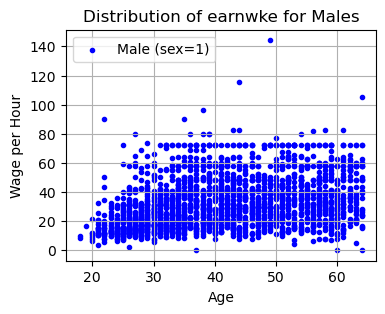

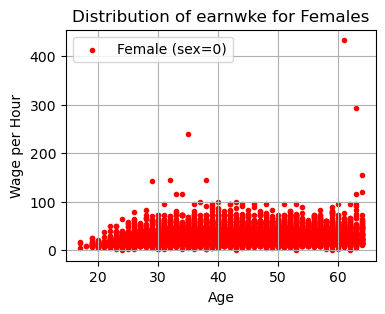

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


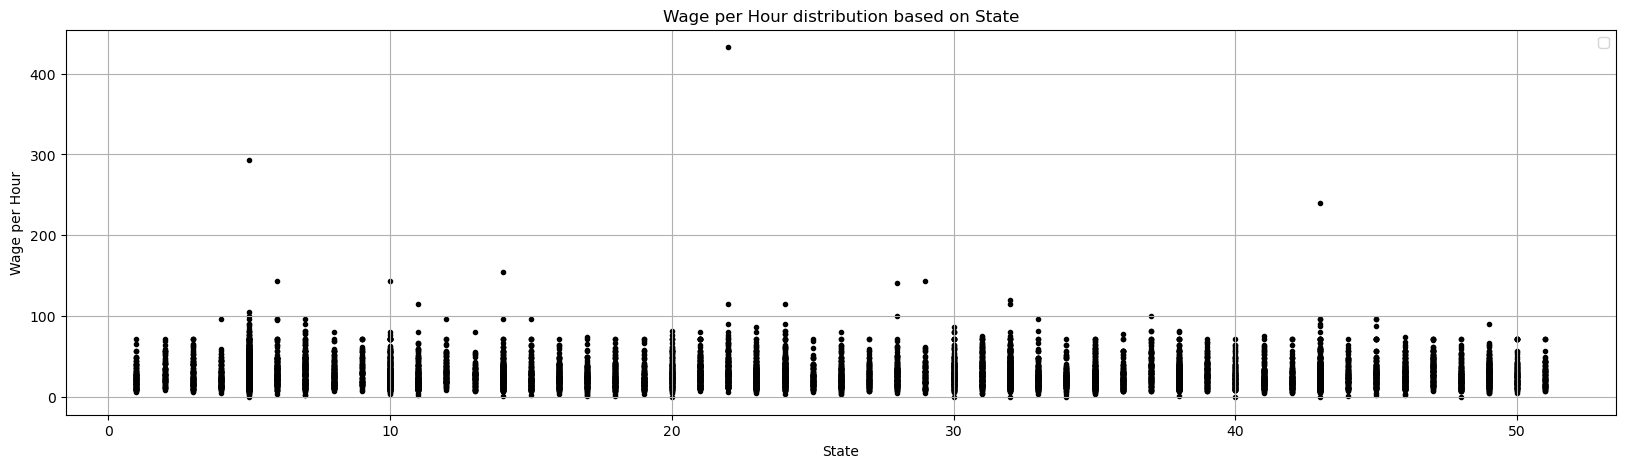

In [8]:
data_male = data[data['sex'] == 1]
data_female = data[data['sex'] == 0]
plt.figure(figsize=(4, 3))
plt.scatter(data_male['age'], data_male['w'], color='blue', marker='.', label='Male (sex=1)')
plt.title('Distribution of earnwke for Males')
plt.xlabel('Age')
plt.ylabel('Wage per Hour')
plt.legend()
plt.grid(True)
plt.show()
#######
plt.figure(figsize=(4, 3))
plt.scatter(data_female['age'], data_female['w'], color='red', marker='.', label='Female (sex=0)')
plt.title('Distribution of earnwke for Females')
plt.xlabel('Age')
plt.ylabel('Wage per Hour')
plt.legend()
plt.grid(True)
plt.show()
#######
plt.figure(figsize=(20, 5))
plt.scatter(data['state_code'], data['w'], color='black', marker='.')
plt.title("Wage per Hour distribution based on State")
plt.xlabel('State')
plt.ylabel('Wage per Hour')
plt.legend()
plt.grid(True)
plt.show()


Now we have:
1) chosen a working category which, in this case, is "Healthcare Practitioners and Technical Occupations".
2) Cleaned and organized the dataset 
    2.1) in the two graph we can see how there a different distribution of wages between female and male.
3) we extrapplate some insight from the dataset, which from the original 149316 observations, now has 9208.
4) We are able to visualize data using python libraries such as matplotlib and seaborn.


In [19]:
reg1 = smf.ols(formula="lnw ~ age + agesqr", data=data).fit()
reg1.summary()
predicted_values = reg1.predict()
actual_values = data['lnw']
mse = mean_squared_error(actual_values, predicted_values)
print("Mean Squared Error (MSE):", mse)
print(reg1.summary())

Mean Squared Error (MSE): 0.352371802544651
                            OLS Regression Results                            
Dep. Variable:                    lnw   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     282.5
Date:                Tue, 07 Nov 2023   Prob (F-statistic):          8.54e-120
Time:                        13:50:02   Log-Likelihood:                -8263.3
No. Observations:                9208   AIC:                         1.653e+04
Df Residuals:                    9205   BIC:                         1.655e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

/Users/jacopobinati/opt/miniconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/jacopobinati/opt/miniconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/jacopobinati/opt/miniconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/jacopobinati/opt/miniconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype

Let's build a second model where we take in consideration a second

In [15]:
reg2 = smf.ols(formula="w ~ age + agesqr + sex", data=data).fit()
reg2.summary()
predicted_values = reg2.predict()
actual_values = data['lnw']
mse = mean_squared_error(actual_values, predicted_values)
print("Mean Squared Error (MSE):", mse)
print(reg2.summary())

Mean Squared Error (MSE): 701.9972403456414
                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     233.0
Date:                Tue, 07 Nov 2023   Prob (F-statistic):          1.06e-145
Time:                        13:47:12   Log-Likelihood:                -38693.
No. Observations:                9208   AIC:                         7.739e+04
Df Residuals:                    9204   BIC:                         7.742e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

/Users/jacopobinati/opt/miniconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/jacopobinati/opt/miniconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/jacopobinati/opt/miniconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/jacopobinati/opt/miniconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype

In [17]:
reg3 = smf.ols(formula="w ~ age + agesqr + sex + state_code", data=data).fit()
reg3.summary()
predicted_values = reg3.predict()
actual_values = data['lnw']
mse = mean_squared_error(actual_values, predicted_values)
print("Mean Squared Error (MSE):", mse)
print(reg3.summary())


Mean Squared Error (MSE): 702.5468981143308
                            OLS Regression Results                            
Dep. Variable:                      w   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     180.2
Date:                Tue, 07 Nov 2023   Prob (F-statistic):          6.51e-149
Time:                        13:47:47   Log-Likelihood:                -38683.
No. Observations:                9208   AIC:                         7.738e+04
Df Residuals:                    9203   BIC:                         7.741e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

/Users/jacopobinati/opt/miniconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/jacopobinati/opt/miniconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/jacopobinati/opt/miniconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/jacopobinati/opt/miniconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype